In [9]:
from enum import auto
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics  import classification_report, confusion_matrix,accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping


In [10]:
# Bỏ qua hàng đầu tiên, dùng hàng 2 làm header
df = pd.read_csv("SWAT.csv",header=1, low_memory=False)

In [11]:
time_candidates = [c for c in df.columns if 'time' in c.lower() or 'timestamp' in c.lower()]
if not time_candidates:
    timestamp_col = df.columns[0]
else:
    timestamp_col = time_candidates[0]

df = df[~df[timestamp_col].astype(str).str.lower().eq(timestamp_col.lower())]
df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)
df = df.dropna(subset=[timestamp_col])
df = df.set_index(timestamp_col)

print("Cột thời gian được sử dụng:", timestamp_col)

Cột thời gian được sử dụng: GMT +0


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_19772\1033324384.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[timestamp_col] = pd.to_datetime(df[timestamp_col], errors="coerce", utc=True)


In [12]:
attack_periods = [
    # Attack 1: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:08:46', '2019-07-20 07:10:31'),
    # Attack 2: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:15:00', '2019-07-20 07:19:32'),
    # Attack 3: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:26:57', '2019-07-20 07:30:48'),
    # Attack 4: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:38:50', '2019-07-20 07:46:20'),
    # Attack 5: 15h (GMT+8) -> 7h (GMT+0)
    ('2019-07-20 07:54:00', '2019-07-20 07:56:00'),
    # Attack 6: 16h (GMT+8) -> 8h (GMT+0)
    ('2019-07-20 08:02:56', '2019-07-20 08:16:18')
]

attack_datetime_periods = [
    (pd.to_datetime(start).tz_localize("UTC"), pd.to_datetime(end).tz_localize("UTC"))
    for start, end in attack_periods
]

df['Attack'] = 0
for start, end in attack_datetime_periods:
    df.loc[start:end, 'Attack'] = 1

print("Số mẫu Attack:", df['Attack'].sum())
print("Tỷ lệ Attack:", df['Attack'].mean() * 100)

Số mẫu Attack: 1981
Tỷ lệ Attack: 13.210189383835688


In [13]:
plt.rcParams['figure.figsize'] = (15, 5)
status_cols = [col for col in df.columns if df[col].astype(str).str.contains("Active|Inactive", case=False).any()]

print("\n Các cột có Active/Inactive:", status_cols)

for col in status_cols:
    df[col] = df[col].map({'Active': 1, 'Inactive': 0})

# print(df[status_cols].head())

target_column = 'Attack'
feature_columns = df.columns.drop(target_column)

for col in feature_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

feature_std = df[feature_columns].std()
useless_columns = feature_std[feature_std == 0].index

if not useless_columns.empty:
    print("\nCác cột không có biến thiên (std=0) và có thể loại bỏ:")
    print(list(useless_columns))
    print("Số cột bị loại bỏ:", len(useless_columns))
    # df.drop(columns=useless_columns, inplace=True)
else:
    print("\nKhông có cột nào bị loại bỏ do không có biến thiên.")


 Các cột có Active/Inactive: ['LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'LS 401', 'LSH 601', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603']

Các cột không có biến thiên (std=0) và có thể loại bỏ:
['P102 Status', 'LS 201', 'LS 202', 'LSL 203', 'LSLL 203', 'P2_STATE', 'P201 Status', 'P202 Status', 'P204 Status', 'P206 Status', 'P207 Status', 'P208 Status', 'P302 Status', 'AIT 401', 'LS 401', 'P4_STATE', 'P402 Status', 'P403 Status', 'P404 Status', 'MV 502', 'MV 503', 'MV 504', 'P5_STATE', 'P501 Status', 'P502 Status', 'LSH 602', 'LSH 603', 'LSL 601', 'LSL 602', 'LSL 603', 'P6 STATE', 'P602 Status', 'P603 Status']
Số cột bị loại bỏ: 33


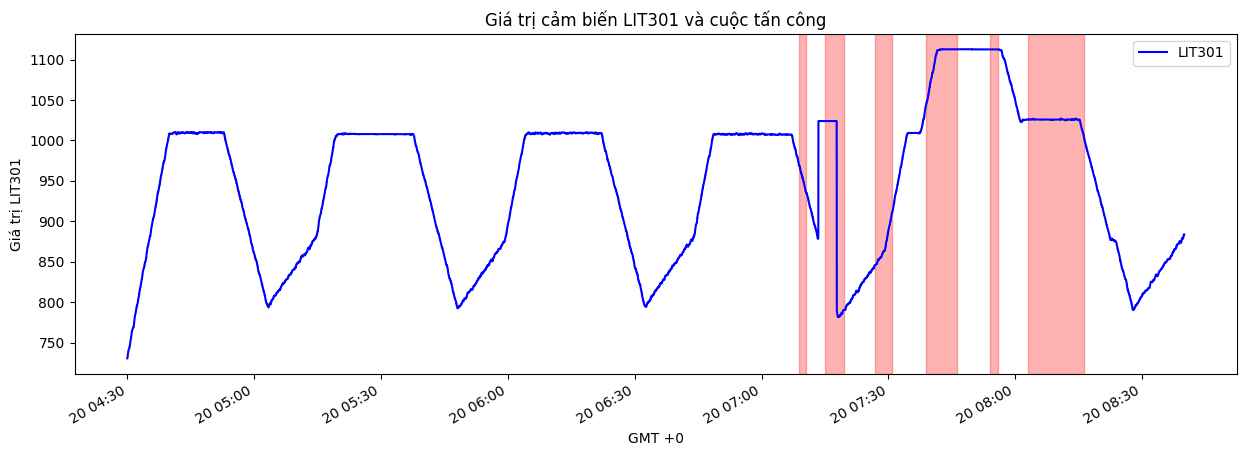

In [14]:
# --------------------------------------------------------------------------------
# Visualize attack periods on a specific sensor
fig, ax = plt.subplots()

df['LIT 301'].plot(ax=ax, label='LIT301', color='blue')

for start, end in attack_datetime_periods: # Vẽ vùng tất cả các cuộc tấn công
    ax.axvspan(start, end, color='red', alpha=0.3, label ='_nolegend_')

ax.set_title('Giá trị cảm biến LIT301 và cuộc tấn công')
ax.set_ylabel('Giá trị LIT301')
ax.legend()
plt.show()

                                     LIT 301   AIT 301     AIT 302
GMT +0                                                            
2019-07-20 04:30:00+00:00         730.702100  8.522921  256.431274
2019-07-20 04:30:01+00:00         730.902344  8.522921  256.431274
2019-07-20 04:30:02.004013+00:00  732.344300  8.522921  256.431274
2019-07-20 04:30:03.004013+00:00  732.704800  8.522921  256.431274
2019-07-20 04:30:04+00:00         732.744800  8.522921  256.431274


array([<Axes: xlabel='GMT +0'>, <Axes: xlabel='GMT +0'>,
       <Axes: xlabel='GMT +0'>], dtype=object)

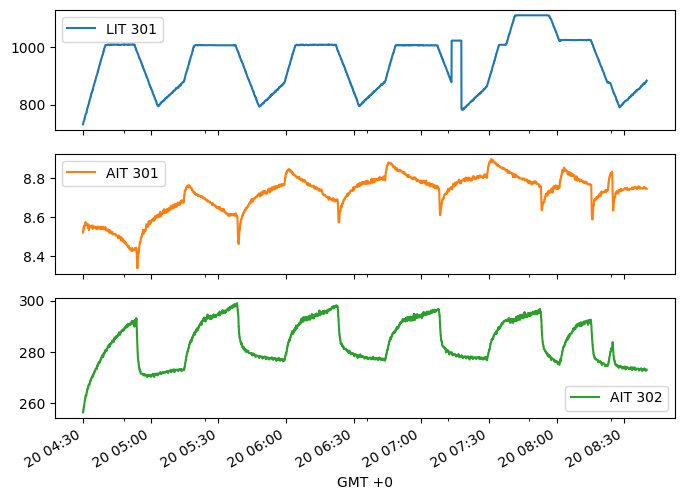

In [15]:
features_considered = ['LIT 301', 'AIT 301', 'AIT 302']

feature = df[features_considered]
print(feature.head())
feature.plot(subplots=True, figsize=(8, 6))


Không tìm thấy cột nào chứa toàn giá trị NaN.


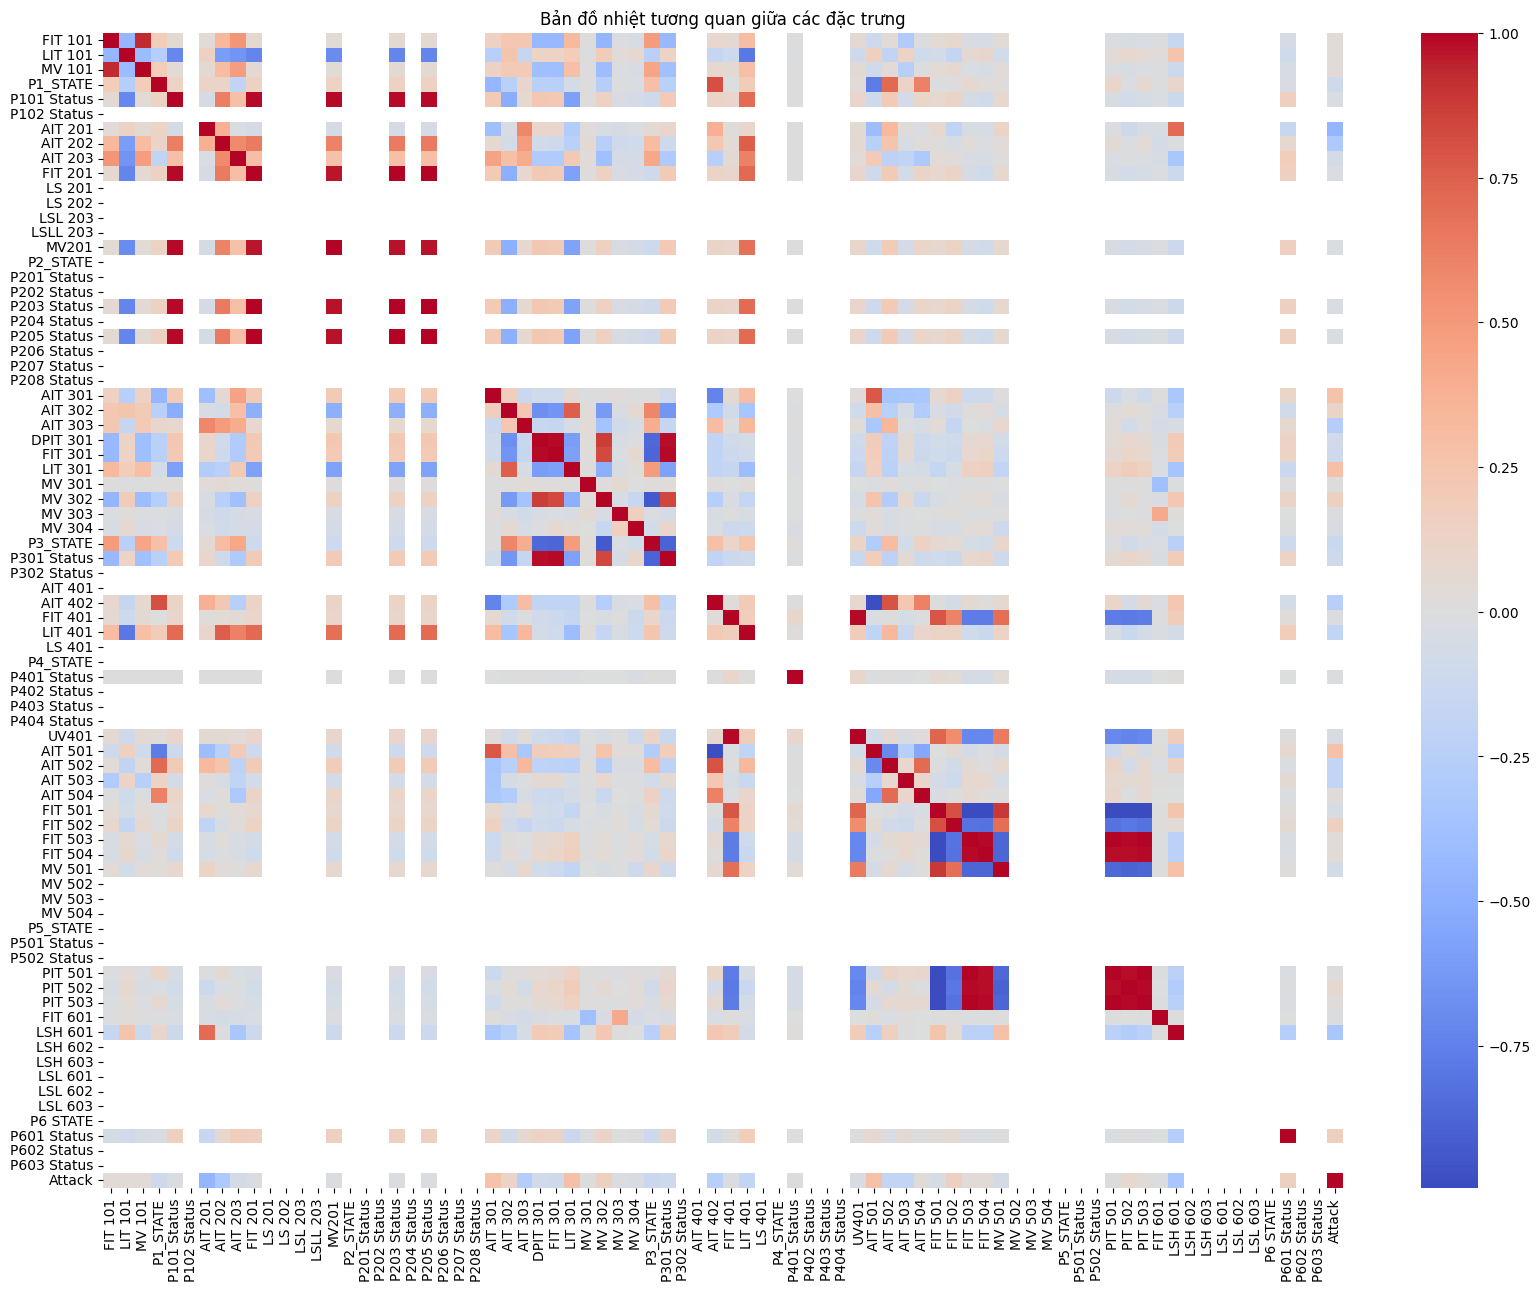

In [16]:
#--------------------------------------------------------------------------------\
# Feature correlations analysis

nan_columns = df.columns[df.isnull().all()]

if not nan_columns.empty:
    print("\nCÁC CỘT BỊ TRỐNG TRÊN HEATMAP (do toàn giá trị NaN):")
    print(list(nan_columns))
else:
    print("\nKhông tìm thấy cột nào chứa toàn giá trị NaN.")

corr_matrix = df.corr() 

plt.figure(figsize=(20, 15))

sns.heatmap(corr_matrix, cmap='coolwarm', center=0)

plt.title('Bản đồ nhiệt tương quan giữa các đặc trưng')

plt.show()

In [17]:
#---------------------------------------------------------------------------------
# Select top features based on correlation with 'Attack'

selected_features = ['FIT 101', 'LIT 101', 'MV 101', 'P1_STATE', 'P101 Status', 'AIT 201', 'AIT 202', 'AIT 203', 'FIT 201', 'MV201', 'P203 Status', 'P205 Status',
                    'AIT 301', 'AIT 302', 'AIT 303', 'DPIT 301', 'FIT 301', 'LIT 301', 'MV 301', 'MV 302', 'MV 303', 'MV 304', 'P3_STATE', 'P301 Status', 
                    'AIT 402', 'FIT 401', 'LIT 401', 'P401 Status', 'UV401', 'AIT 501', 'AIT 502', 'AIT 503', 'AIT 504', 'FIT 501', 'FIT 502', 'FIT 503',
                    'FIT 504', 'MV 501', 'PIT 501', 'PIT 502', 'PIT 503', 'FIT 601', 'LSH 601', 'P601 Status']


df_model = df[selected_features + ['Attack']].copy()

print(f"Đã tạo DataFrame mới với {len(selected_features)} đặc trưng được chọn.")

print(df_model.head())


Đã tạo DataFrame mới với 44 đặc trưng được chọn.
                                  FIT 101   LIT 101  MV 101  P1_STATE  \
GMT +0                                                                  
2019-07-20 04:30:00+00:00             0.0  729.8658       1         3   
2019-07-20 04:30:01+00:00             0.0  729.4340       1         3   
2019-07-20 04:30:02.004013+00:00      0.0  729.1200       1         3   
2019-07-20 04:30:03.004013+00:00      0.0  728.6882       1         3   
2019-07-20 04:30:04+00:00             0.0  727.7069       1         3   

                                  P101 Status     AIT 201   AIT 202  \
GMT +0                                                                
2019-07-20 04:30:00+00:00                   2  142.527557  9.293002   
2019-07-20 04:30:01+00:00                   2  142.527557  9.293002   
2019-07-20 04:30:02.004013+00:00            2  142.527557  9.293002   
2019-07-20 04:30:03.004013+00:00            2  142.527557  9.289157   
2019-07-20 04

In [18]:
#---------------------------------------------------------------------------------
# missing value imputation


print(f"Số giá trị NaN trước khi xử lý: {df_model.isnull().sum().sum()}")

df_model.ffill(inplace=True)

df_model.bfill(inplace=True)

print(f"Số giá trị NaN sau khi xử lý: {df_model.isnull().sum().sum()}")

Số giá trị NaN trước khi xử lý: 0
Số giá trị NaN sau khi xử lý: 0


In [19]:
#- ---------------------------------------------------------------------------
# Split data into train and test sets based on time

from sklearn.model_selection import train_test_split

split_timestamp = pd.to_datetime('2019-07-20 07:00:00').tz_localize("UTC")

df_train = df_model.loc[df_model.index <= split_timestamp]

df_test = df_model.loc[df_model.index > split_timestamp]

print("split timestamp:", split_timestamp)
print(f"Train set: {df_train.shape}, Test set: {df_test.shape}")

# df_before_attack = df_model.loc[df_model.index <= split_timestamp]
# df_after_attack = df_model.loc[df_model.index > split_timestamp]

# df_train_core = df_before_attack.copy()

# df_normal_after_attack = df_after_attack[df_after_attack['Attack'] == 0]

# df_attacks = df_after_attack[df_after_attack['Attack'] == 1]

# df_normal_to_add_to_train, df_normal_for_test = train_test_split(df_normal_after_attack, test_size=0.5, random_state=42) 

# df_train = pd.concat([df_train_core, df_normal_to_add_to_train])
# df_test = pd.concat([df_normal_for_test, df_attacks])

# df_train.sort_index(inplace=True)
# df_test.sort_index(inplace=True)

# print("--- Phân chia dữ liệu kết hợp hoàn tất ---")
# print(f"Kích thước tập Train mới: {df_train.shape}")
# print(f"Kích thước tập Test mới: {df_test.shape}")



split timestamp: 2019-07-20 07:00:00+00:00
Train set: (8996, 45), Test set: (6000, 45)


In [20]:
# label distribution

print("\n--- Phân bố nhãn trong tập train ---")
print(df_train['Attack'].value_counts())

print("\n--- Phân bố nhãn trong tập test ---")
print(df_test['Attack'].value_counts())

X_train = df_train[selected_features]
y_train = df_train['Attack']

X_test = df_test[selected_features]
y_test = df_test['Attack']

print("Completed data preprocessing and splitting!")


--- Phân bố nhãn trong tập train ---
Attack
0    8996
Name: count, dtype: int64

--- Phân bố nhãn trong tập test ---
Attack
0    4019
1    1981
Name: count, dtype: int64
Completed data preprocessing and splitting!


In [21]:
#---------------------------------------------------------------------------------
# Chuẩn hóa dữ liệu(data scaling)



scaler = MinMaxScaler(feature_range=(-1, 1))

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Dữ liệu đã được chuẩn hóa.")

# X_train_core = df_train_core[selected_features]

# scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler.fit(X_train_core)

# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# print("Dữ liệu đã được chuẩn hóa.")




Dữ liệu đã được chuẩn hóa.


In [23]:
#---------------------------------------------------------------------------------
# Train LSTM Autoencoder model

def create_cnn_lstm_sequences(X, y, past_history=720, future_target=72):
    Xs, ys, y_attack = [], [], []
    for i in range(past_history, len(X) - future_target):
        indices_x = range(i - past_history, i)
        Xs.append(X[indices_x]) 

        indices_y = range(i, i + future_target)     
        ys.append(X[indices_y]) 

        y_attack.append(1 if 1 in y[indices_y] else 0)
    return np.array(Xs), np.array(ys), np.array(y_attack)

PAST_HISTORY = 200
FUTURE_TARGET = 72

X_train_seq, y_train_seq, _ = create_cnn_lstm_sequences(
    X_train_scaled, y_train.values, PAST_HISTORY, FUTURE_TARGET
)
X_test_seq, y_test_seq, y_test_attack_labels = create_cnn_lstm_sequences(
    X_test_scaled, y_test.values, PAST_HISTORY, FUTURE_TARGET
)

print(f"Hình dạng dữ liệu train: X={X_train_seq.shape}, y={y_train_seq.shape}")
print(f"Hình dạng dữ liệu test: X={X_test_seq.shape}, y={y_test_seq.shape}")
print(f"Hình dạng nhãn test: {y_test_attack_labels.shape}")
print("Hoàn tất.\n")

Hình dạng dữ liệu train: X=(8724, 200, 44), y=(8724, 72, 44)
Hình dạng dữ liệu test: X=(5728, 200, 44), y=(5728, 72, 44)
Hình dạng nhãn test: (5728,)
Hoàn tất.



In [24]:
n_past_steps, n_features = X_train_seq.shape[1], X_train_seq.shape[2]
n_future_steps = y_train_seq.shape[1]

model_cnn_lstm = Sequential([
    Conv1D(filters=64, kernel_size=7,padding='same', activation='relu', input_shape=(n_past_steps, n_features)),
    Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    Dropout(0.2),
    # LSTM(32, return_sequences=True),
    # Dropout(0.2),
    LSTM(16),
    Dropout(0.2),
    Dense(n_future_steps * n_features),
    tf.keras.layers.Reshape((n_future_steps, n_features)) # Reshape lại thành dạng chuỗi
])

model_cnn_lstm.compile(optimizer='adam', loss='mae')
model_cnn_lstm.summary()


c:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 200, 64)        │        19,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 200, 32)        │        14,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3168)           │        53,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 72, 44)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 91,136 (356.00 KB)

 Trainable params: 91,136 (356.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 99ms/step - loss: 0.6114 - val_loss: 0.5128
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.3969 - val_loss: 0.3227
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - loss: 0.3428 - val_loss: 0.3118
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - loss: 0.3389 - val_loss: 0.3133
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.3334 - val_loss: 0.3183
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.3146 - val_loss: 0.3036
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.2740 - val_loss: 0.2527
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - loss: 0.2378 - val_loss: 0.2157
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - loss: 0.2225 - val_loss: 0.2037
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.2131 - val_loss: 0.1961
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 0.2050 - val_loss: 0.1896
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 11s 227ms/step - loss:

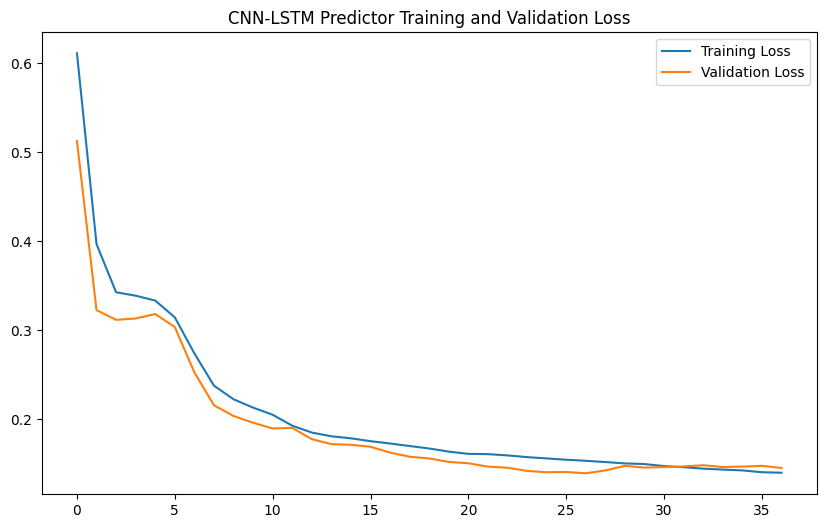

In [ ]:
#---------------------------------------------------------------------------------
# Training LSTM Autoencoder

early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', restore_best_weights=True)

history = model_cnn_lstm.fit(X_train_seq, y_train_seq,
                             epochs=50,
                             batch_size=256,
                             validation_split=0.1,
                             callbacks=[early_stopping],
                             shuffle=True)

# Trực quan hóa loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CNN-LSTM Predictor Training and Validation Loss')
plt.legend() 
plt.show()

--- BƯỚC 6: Đánh giá mô hình ---
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Ngưỡng Lỗi DỰ ĐOÁN được xác định là: 0.2349
179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

--- Báo cáo Phân loại (CNN-LSTM Predictor) ---
              precision    recall  f1-score   support

  Normal (0)       0.65      0.21      0.32      3321
  Attack (1)       0.44      0.84      0.58      2407

    accuracy                           0.48      5728
   macro avg       0.55      0.53      0.45      5728
weighted avg       0.56      0.48      0.43      5728


--- Ma trận nhầm lẫn (CNN-LSTM Predictor) ---


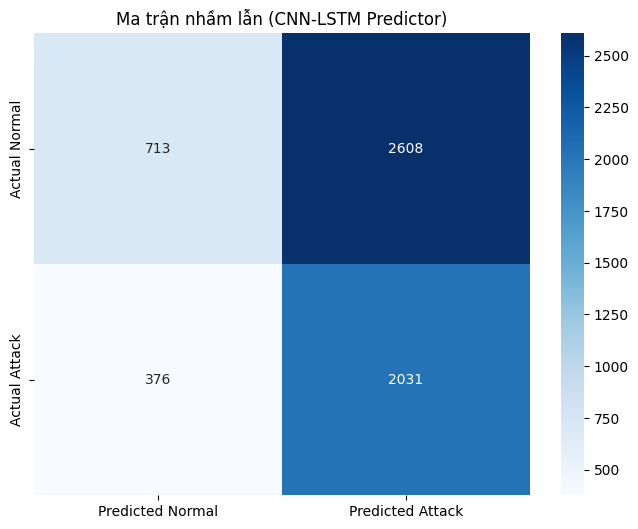

Quy trình hoàn tất.


In [51]:
print("--- BƯỚC 6: Đánh giá mô hình ---")

# 6.1. Tính lỗi dự đoán trên tập train để tìm ngưỡng
train_predictions = model_cnn_lstm.predict(X_train_seq)
train_mae_loss = np.mean(np.abs(train_predictions - y_train_seq), axis=(1, 2))
threshold = np.percentile(train_mae_loss, 99) # Dùng percentile 99
print(f"Ngưỡng Lỗi DỰ ĐOÁN được xác định là: {threshold:.4f}")

# 6.2. Tính lỗi dự đoán trên tập test
test_predictions = model_cnn_lstm.predict(X_test_seq)
test_mae_loss = np.mean(np.abs(test_predictions - y_test_seq), axis=(1, 2))
predictions = (test_mae_loss > threshold).astype(int)

# 6.3. In báo cáo và ma trận nhầm lẫn
# Sử dụng nhãn y_test_attack_labels mà chúng ta đã tạo
print("\n--- Báo cáo Phân loại (CNN-LSTM Predictor) ---")
print(classification_report(y_test_attack_labels, predictions, target_names=['Normal (0)', 'Attack (1)']))

print("\n--- Ma trận nhầm lẫn (CNN-LSTM Predictor) ---")
cm = confusion_matrix(y_test_attack_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Normal', 'Predicted Attack'],
            yticklabels=['Actual Normal', 'Actual Attack'])
plt.title('Ma trận nhầm lẫn (CNN-LSTM Predictor)')
plt.show()
print("Quy trình hoàn tất.")
